# Pixel Response

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [23]:
#os
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#this is us
import autometacal as amc
import tensorflow as tf

#...vs them!
import ngmix
import galsim
from multiprocessing import Pool

## Exploring the GalSim Pixel

In [3]:
psf=galsim.Moffat(beta=2.5,fwhm = 0.9)
pix=galsim.Pixel(scale=1.)
invpix=galsim.Deconvolve(pix)
psfopix = galsim.Convolve([psf,invpix])

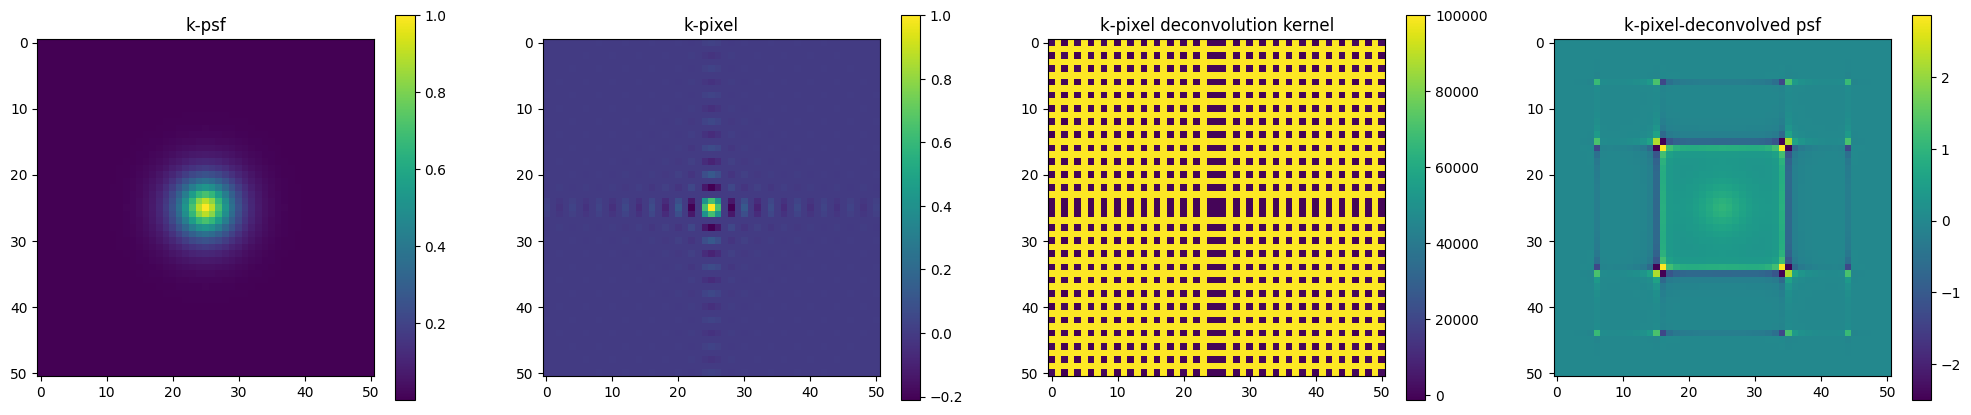

In [4]:
figure(figsize=(25,5))

subplot(141)
psfimk = psf.drawKImage(nx=51,ny=51).array
imshow(real(psfimk));colorbar();title('k-psf')

subplot(142)
piximk = pix.drawKImage(nx=51,ny=51).array
imshow(real(piximk));colorbar();title('k-pixel')

subplot(143)
invpiximk = invpix.drawKImage(nx=51,ny=51).array
imshow(real(invpiximk));colorbar();title('k-pixel deconvolution kernel')

subplot(144)
psfopiximk=psfopix.drawKImage(nx=51,ny=51).array
imshow(real(psfopiximk));colorbar();title('k-pixel-deconvolved psf')
savefig('deconvolve_in_k_space.jpg')

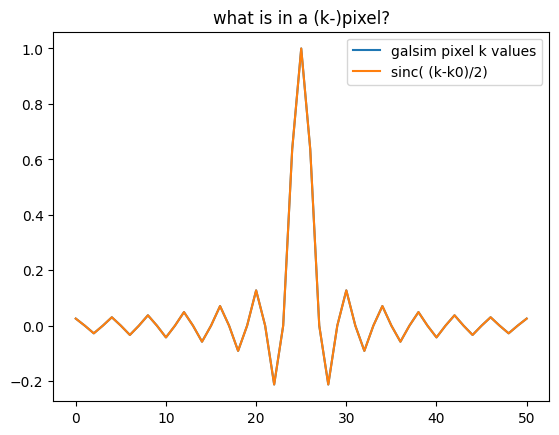

In [5]:
plot(real(piximk[:,25]),label='galsim pixel k values')
k = linspace(0,50,51)
y = sinc((k-25) *0.5)
plot(k,y,label='sinc( (k-k0)/2)')
title('what is in a (k-)pixel?');
legend()
savefig('what_is_pix.jpg')

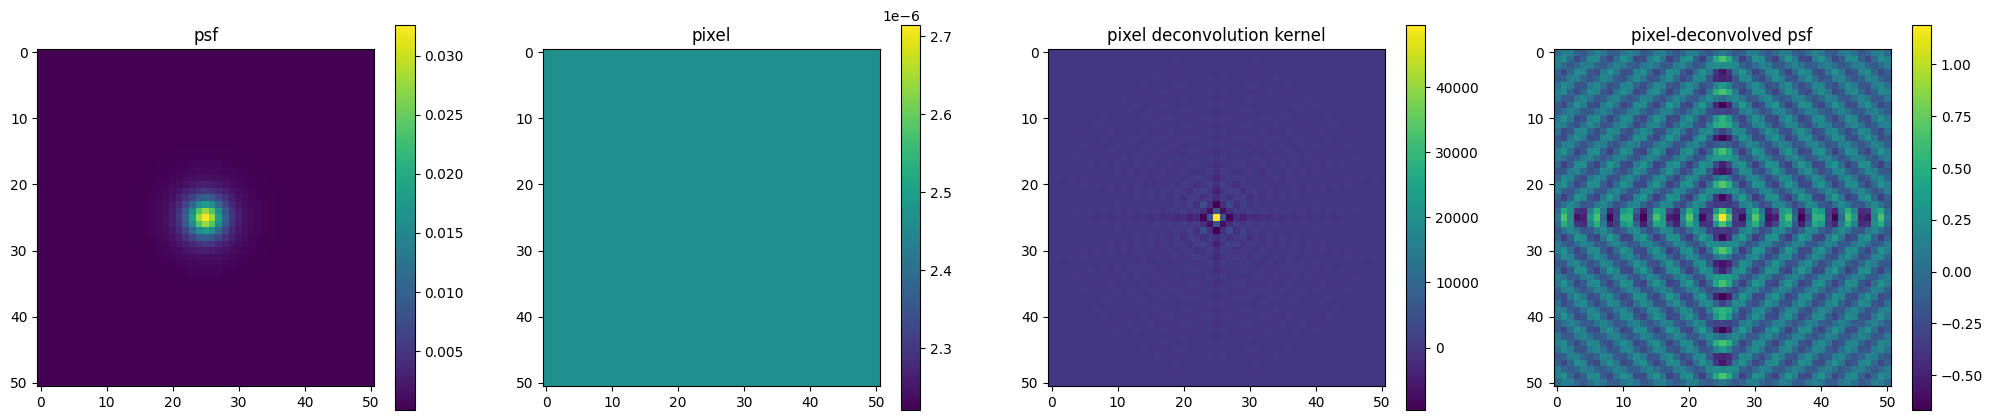

In [6]:
figure(figsize=(25,5))

subplot(141)
psfim = psf.drawImage(nx=51,ny=51).array
imshow(real(psfim));colorbar();title('psf')

subplot(142)
pixim = pix.drawImage(nx=51,ny=51).array
imshow(real(pixim));colorbar();title('pixel')

subplot(143)
invpixim = invpix.drawImage(nx=51,ny=51).array
imshow(real(invpixim));colorbar();title('pixel deconvolution kernel')

subplot(144)
psfopixim=psfopix.drawImage(nx=51,ny=51).array
imshow(real(psfopixim));colorbar();title('pixel-deconvolved psf')
savefig('deconvolve_in_x_space.jpg')

## Exploring our FFT routines

In [7]:
def makekpsf(psf,dtypes='complex64'):
  psf_complex = tf.cast(psf, dtype=dtypes)
  psf_fft = tf.signal.fft2d(psf_complex)
  psf_fft_abs = tf.abs(psf_fft)
  psf_fft_abs_complex = tf.cast(psf_fft_abs,dtype=dtypes)
  kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])
  return psf_fft

def makekimg(img,dtypes='complex64'):
  im_shift = tf.signal.ifftshift(img,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, dtypes)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  return imk

In [8]:
kpsf_tf = makekimg(psfim[tf.newaxis])[0]

In [9]:
boxsize = 50
padsize = 25
finsize= 51
constant = 1/(boxsize)**2#*pi**2/4
box = tf.convert_to_tensor(np.ones([boxsize,boxsize])*constant)
paddings = tf.constant([[padsize, padsize], [padsize, padsize]])
boxpad = tf.pad(box,paddings)
kbox=makekimg(boxpad[tf.newaxis])[0]

In [10]:
centre = (boxsize+2*padsize)//2
kboxtrim=kbox[centre-finsize//2:centre+finsize//2+1,centre-finsize//2:centre+finsize//2+1]

Text(0.5, 1.0, 'difference')

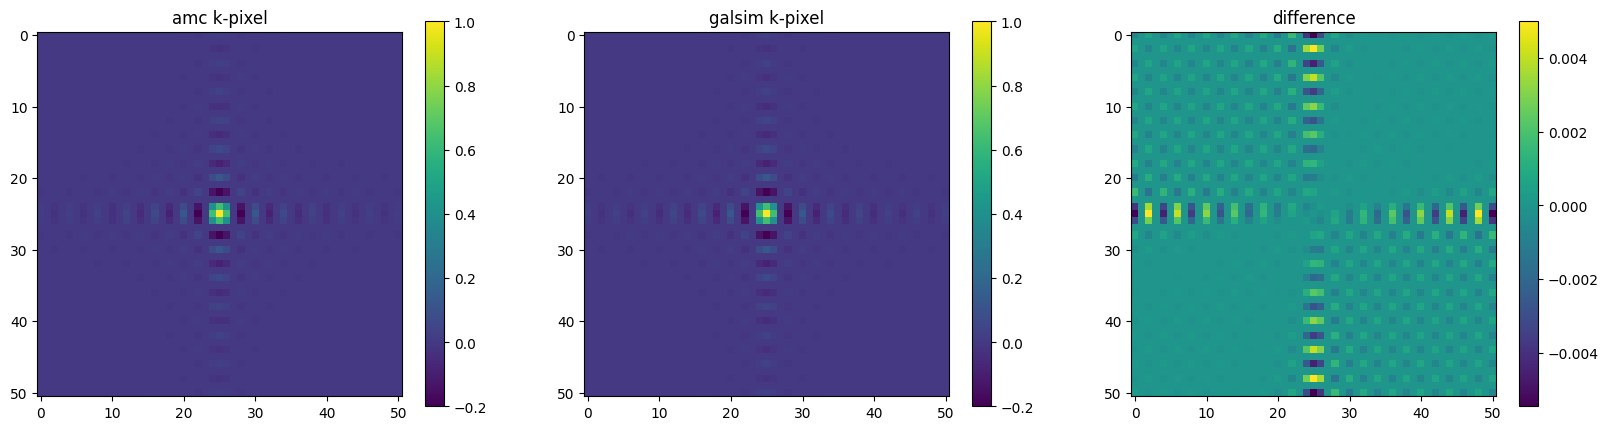

In [11]:
figure(figsize=(20,5))
subplot(131)
imshow(real(kboxtrim));clim(-.2,1);colorbar();title('amc k-pixel')
subplot(132)
imshow(real(piximk));clim(-.2,1);colorbar();title('galsim k-pixel')
subplot(133)
imshow(real(kboxtrim)-real(piximk));colorbar();title('difference')

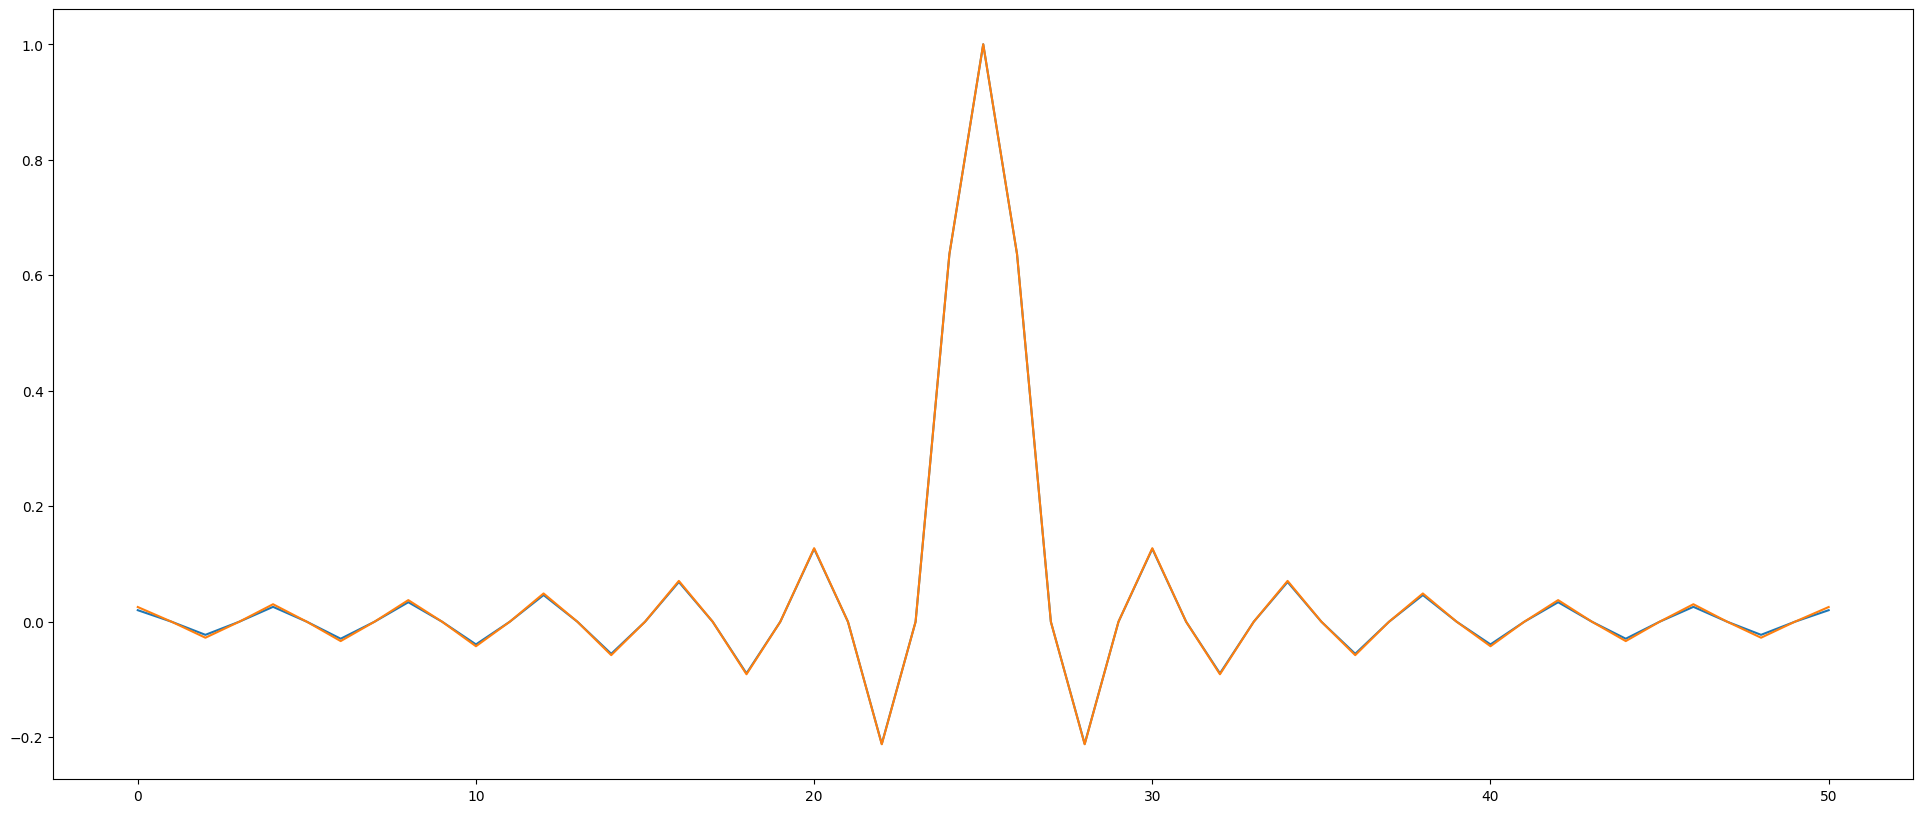

In [12]:
figure(figsize=(24,10))
plot(real(kboxtrim)[:,25])
plot(real(piximk)[:,25])

## What is a pixel deconvolution kernel in k-space?

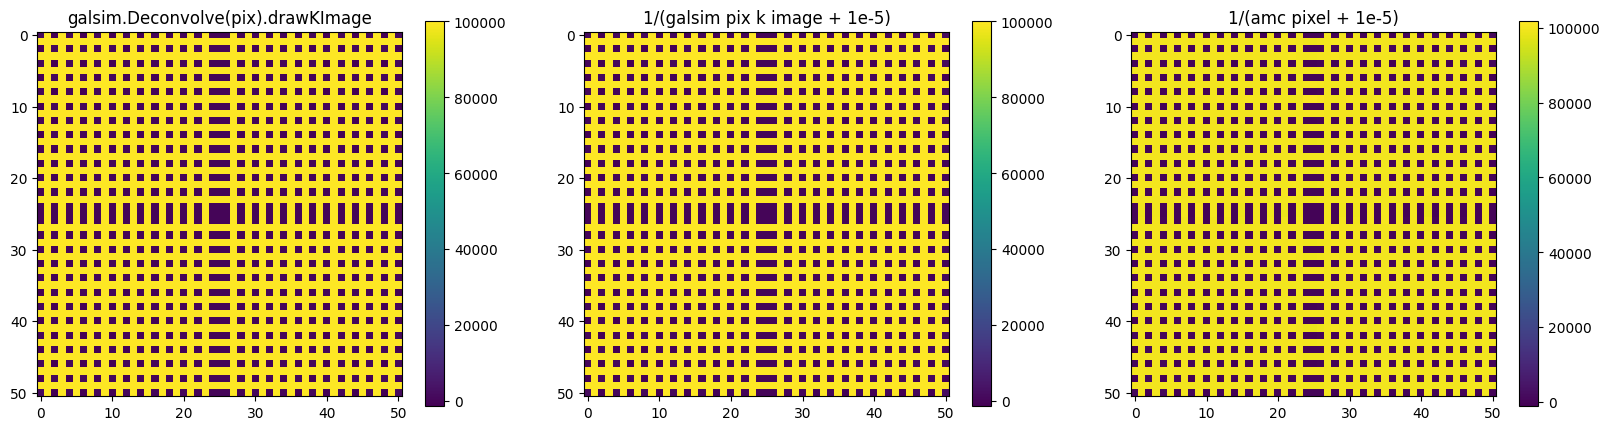

In [13]:
figure(figsize=(20,5))
subplot(131)
imshow(real(invpiximk));colorbar();title('galsim.Deconvolve(pix).drawKImage')
subplot(132)
imshow(real(1/(piximk+1e-5)) );colorbar();title('1/(galsim pix k image + 1e-5)') #kvalue_accuracy = 1e-5 from GSParams
subplot(133)
imshow(real(1/(kboxtrim+1e-5)));colorbar();title('1/(amc pixel + 1e-5)')
savefig('pixel_deconvolve.jpg')

## Trying to get Deconvolve Right

In [14]:
boxsize = 50
padsize = 25
finsize= 51
constant = 1/(boxsize)**2#*pi**2/4
box = tf.convert_to_tensor(np.ones([boxsize,boxsize])*constant)
paddings = tf.constant([[padsize, padsize], [padsize, padsize]])
boxpad = tf.pad(box,paddings)
kbox=makekimg(boxpad[tf.newaxis])[0]
centre = (boxsize+2*padsize)//2
kboxtrim=kbox[centre-finsize//2:centre+finsize//2+1,centre-finsize//2:centre+finsize//2+1]

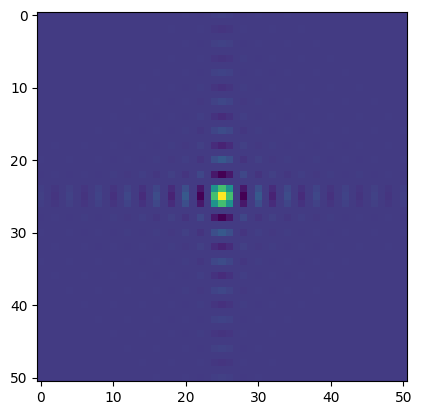

In [15]:
imshow(real(kboxtrim))

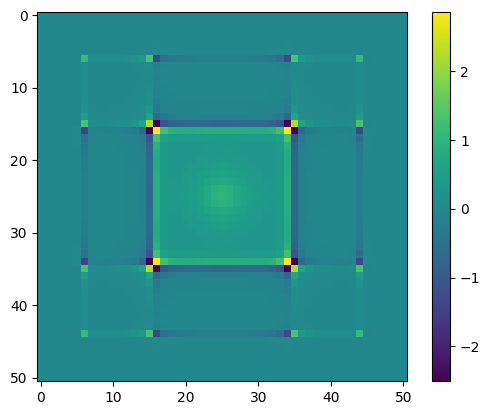

In [16]:
imshow(real(psfopiximk));colorbar()

Text(0.5, 1.0, 'psf')

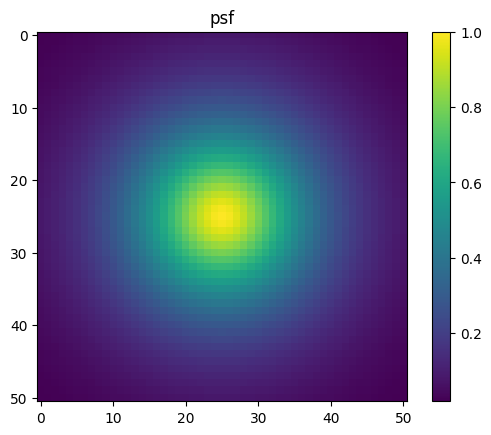

In [17]:
psf=galsim.Moffat(beta=2.5,fwhm = .9*(1+2*.02))
psfimk = psf.drawKImage(nx=51,ny=51,scale=.2).array
imshow(real(psfimk));colorbar();title('psf')

/home/vitorelli/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/resource_loader.py:78: UserWarning: You are currently using TensorFlow 2.7.0 and trying to load a custom op (custom_ops/image/_resampler_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.8.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.8.0 and strictly below 2.9.0.
 Note that nightly versions of TensorFlow, as well as non-pip Tensor

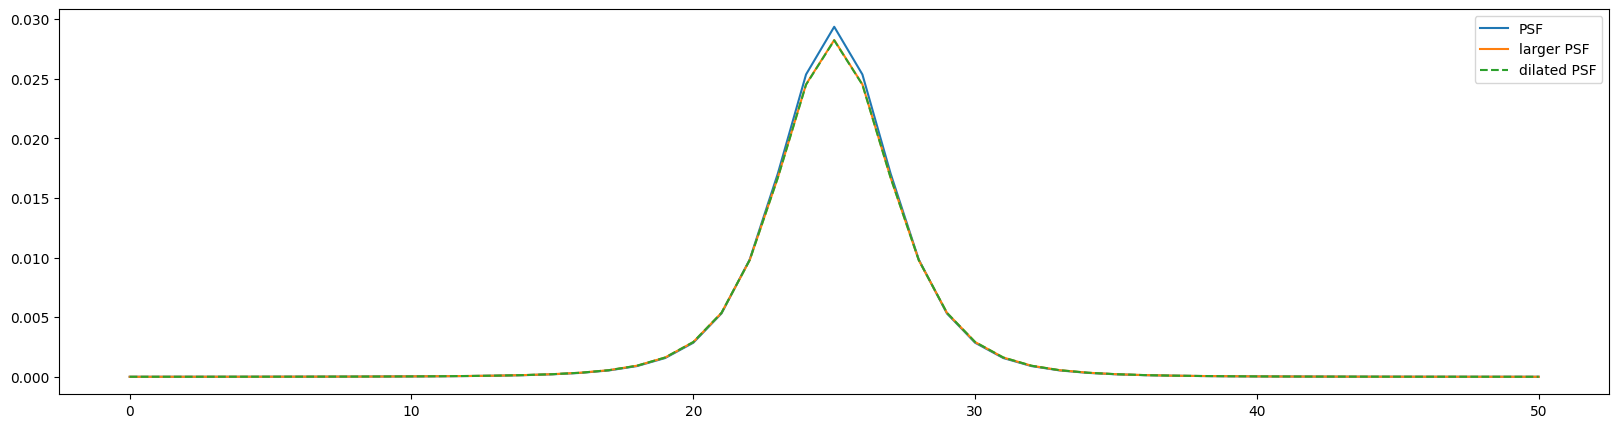

In [18]:
psf=galsim.Moffat(beta=2.5,fwhm = .9)
psfdil = galsim.Moffat(beta=2.5,fwhm = .9*(1+2*.01))
psfim = psf.drawImage(nx=51,ny=51,scale=.2).array
psfamcdilim = amc.dilate(psfim[tf.newaxis,...,tf.newaxis],1+2*.01)[0,...,0]
psfdilim = psfdil.drawImage(nx=51,ny=51,scale=.2).array

figure(figsize=(20,5))
plot(psfim[:,25],label='PSF')
plot(psfdilim[:,25],label='larger PSF')
plot(psfamcdilim[:,25],'--',label='dilated PSF')
legend()

In [19]:
psfamcdilim = amc.dilate(psfim[tf.newaxis,...,tf.newaxis],1+2*.01)[0,...,0]
nx = 51
ny = 51
padfactor =3
fact = (padfactor - 1)//2 #how many image sizes to one direction
paddings = tf.constant([ [nx*fact, nx*fact], [ny*fact, ny*fact]])
psfamcdilim = tf.pad(psfamcdilim,paddings)

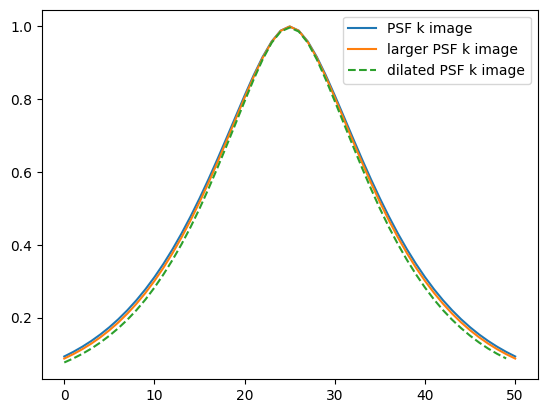

In [20]:
psfimk = psf.drawKImage(nx=51,ny=51,scale=.2).array
psfdilimk = psfdil.drawKImage(nx=51,ny=51,scale=.2).array


psfamcdilimk = makekimg(psfamcdilim[tf.newaxis])
cen = padfactor*nx//2

teste=real(psfamcdilimk[0,cen - fact*nx//2 : cen + fact*nx//2 ,cen])
plot(real(psfimk[:,25]),label='PSF k image')
plot(real(psfdilimk[:,25]),label='larger PSF k image')
plot(teste[:],'--',label='dilated PSF k image')
legend()

In [21]:
g=tf.convert_to_tensor([[0.01,0.01],[0.01,0.0],[0.01,0.0],[0.01,0.0],[0.01,0.0],[0.01,0.0],[0.01,0.0]])

In [22]:
tf.norm(g,axis=1)

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.01414214, 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      ], dtype=float32)>